In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

from scipy.interpolate import interp1d

import nanonets_utils
import nanonets

In [3]:
def plot_freq(f, ax, min_y, max_y, N_f=5):

    ax.vlines(f, min_y, max_y, colors='black', linestyles='solid', label=f"$f_0 = {f}$ GHz")

    for n in range(2,N_f+1):
        ax.vlines(n*f, min_y, max_y, colors='#A60628', linestyles='dotted')
    
    return ax

In [58]:
seed    = 3
R_val   = 200
dic     = {f : pd.read_csv(f"resistance/data/Nx=7_Ny=7_Nz=1_Ne=2_{f}_{R_val}_{seed}.csv") for f in np.round(np.arange(0.3,3.9,0.2),2)}

In [59]:
dic.keys()

dict_keys([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7])

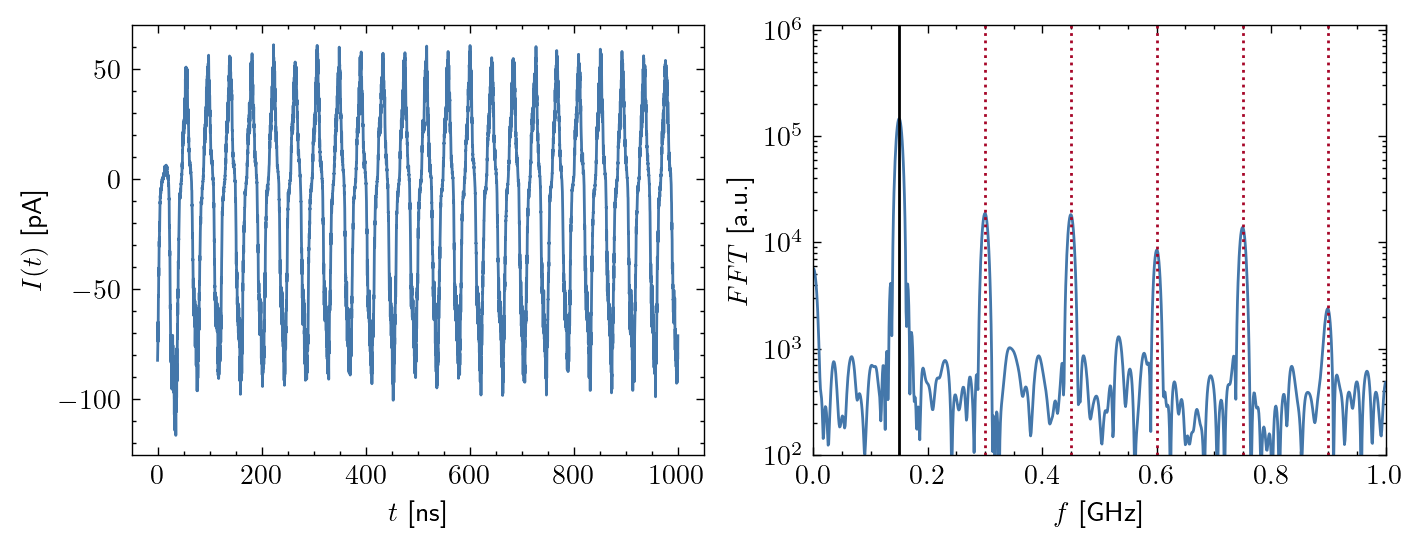

In [60]:
freq    = 1.5
signal  = dic[freq]['Current'].values
dt      = 1e-10
xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=65536)
time    = np.arange(len(signal))*dt*1e9
min_y   = 100
min_x   = 0
max_x   = 1
max_y   = 1.1e6

with plt.style.context(["science", "bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)

    ax = fig.add_subplot(1,2,1)
    ax.plot(time, signal)
    ax.set_ylabel("$I(t)$ [pA]")
    ax.set_xlabel("$t$ [ns]")
    # ax.set_ylim(-100,100)
    # ax.set_xlim(0,50)

    ax  = fig.add_subplot(1,2,2)
    ax.plot(xf,yf)
    ax  = plot_freq(freq/10, ax=ax, min_y=min_y, max_y=max_y, N_f=10)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_yscale('log')
    ax.set_xlabel("$f$ [GHz]")
    ax.set_ylabel("$FFT$ [a.u.]")

    # fig.savefig("plots/fft_output_example.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/fft_output_example.svg", transparent=True, bbox_inches='tight')

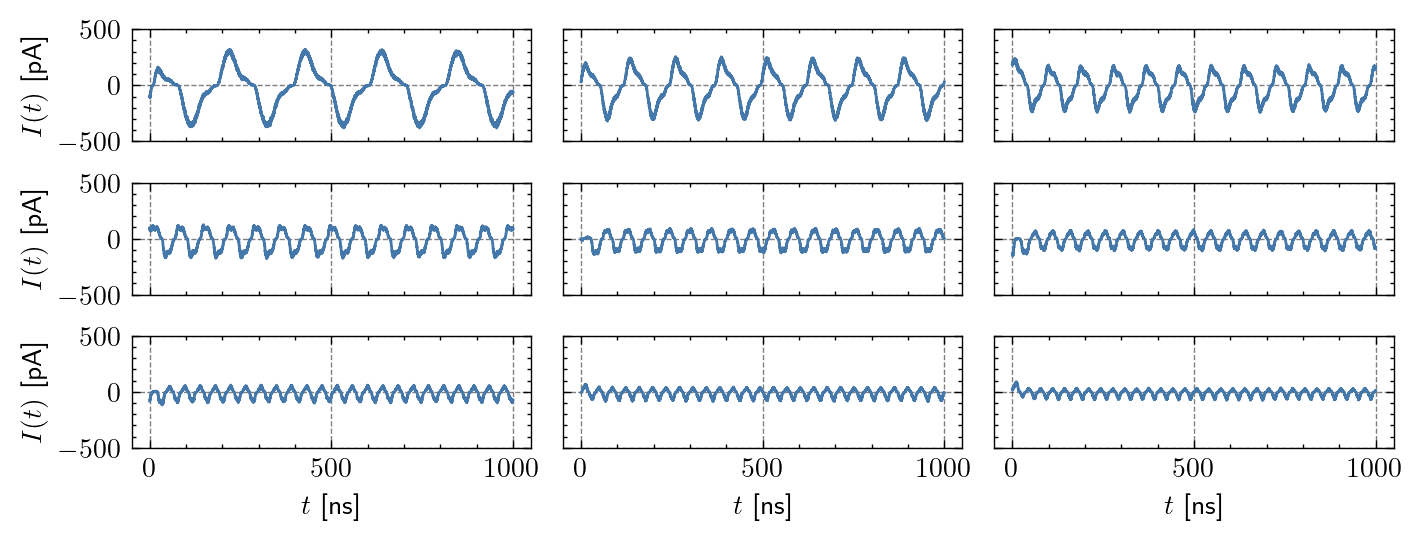

In [61]:
cmap    = plt.get_cmap('Reds')
f_vals  = np.round(np.arange(0.3,2,0.2),2)
miny    = 1e1
maxy    = 1e5
dt      = 1e-10
n_rows  = 3
n_cols  = 3

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*1.2)
    
    for i, f in enumerate(f_vals):

        ax      = fig.add_subplot(4,3,i+1)
        signal  = dic[f]['Current'].values
        
        ax.plot(time,signal)

        if i % n_cols == 0:
            ax.set_ylabel('$I(t)$ [pA]')
        else:
            ax.set_yticklabels("")

        if i >= (n_rows-1)*3:
            ax.set_xlabel('$t$ [ns]')
        else:
            ax.set_xticklabels("")

        ax.set_ylim(-500,500)
        
    # fig.savefig("plots/output_comparsion.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/output_comparsion.svg", transparent=True, bbox_inches='tight')

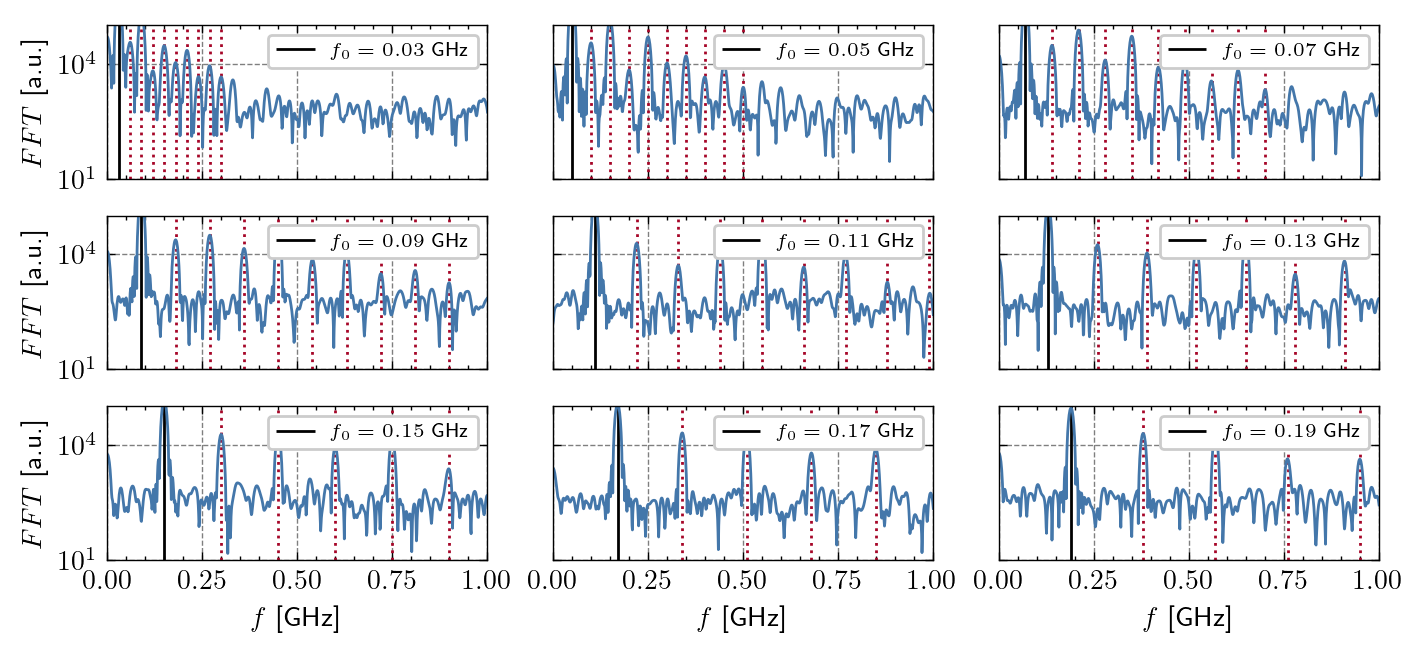

In [62]:
cmap    = plt.get_cmap('Reds')
miny    = 1e1
maxy    = 1e5
dt      = 1e-10
n_rows  = 3
n_cols  = 3

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*1.2)
    
    for i, f in enumerate(f_vals):

        ax      = fig.add_subplot(n_rows,n_cols,i+1)
        signal  = dic[f]['Current'].values
        
        xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=65536)
        ax      = plot_freq(np.round(f/10,2), ax, miny, maxy, N_f=10)

        ax.plot(xf, yf)
        ax.set_xlim(0,1)
        ax.set_ylim(miny, maxy)
        ax.set_yscale('log')
        ax.legend(fontsize='x-small', loc='upper right')

        if i % n_cols == 0:
            ax.set_ylabel('$FFT$ [a.u.]')
        else:
            ax.set_yticklabels("")

        if i >= (n_rows-1)*3:
            ax.set_xlabel('$f$ [GHz]')
        else:
            ax.set_xticklabels("")

    # fig.savefig("plots/fft_comparsion.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/fft_comparsion.svg", transparent=True, bbox_inches='tight')

In [63]:
def relate_to_fundamental_freq(signal, f, dt, N_f=10):

    xf, yf  = nanonets_utils.fft(signal, dt, n_padded=65536)
    func    = interp1d(xf, yf)

    vals    = []
    for n in range(1,N_f+1):
        vals.append(func(n*f/10))
    
    return np.array(vals)

In [64]:
N_f                 = 10
df_fft_amplitudes   = pd.DataFrame()

for f in dic.keys():
    
    signal  = dic[f]['Current'].values
    vals    = relate_to_fundamental_freq(signal, f, dt, N_f=N_f)

    df_fft_amplitudes[f] = vals

df_nonlinear    = df_fft_amplitudes / df_fft_amplitudes.iloc[0,:]
df_nonlinear    = df_nonlinear.drop(0).reset_index(drop=True)
df_nonlinear

,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9,3.1,3.3,3.5,3.7
0,0.058036,0.068435,0.074909,0.077212,0.081150,0.095606,0.129077,0.179073,0.217830,0.236324,0.270704,0.313897,0.354455,0.388362,0.406929,0.418574,0.420703,0.420542
1,0.321522,0.265136,0.186672,0.101686,0.021551,0.058204,0.125370,0.158305,0.185366,0.192940,0.189016,0.174470,0.167104,0.153256,0.144745,0.140783,0.133697,0.124136
2,0.010483,0.013500,0.030887,0.045963,0.064443,0.071010,0.058303,0.053699,0.047420,0.036388,0.008012,0.012787,0.027889,0.032162,0.030324,0.040800,0.021632,0.033072
3,0.047477,0.097273,0.129600,0.139960,0.137383,0.119328,0.094917,0.067939,0.046283,0.037594,0.026845,0.018966,0.017257,0.014142,0.022588,0.023814,0.021754,0.026729
4,0.017169,0.020461,0.020174,0.023622,0.019558,0.016269,0.015979,0.012548,0.015100,0.010837,0.005710,0.004598,0.002932,0.006209,0.020842,0.013271,0.010490,0.011734
5,0.035954,0.031205,0.028038,0.036979,0.039691,0.035869,0.028712,0.022369,0.016314,0.016834,0.017269,0.011441,0.007564,0.002739,0.010233,0.000502,0.005466,0.012372
6,0.007391,0.008769,0.008752,0.010134,0.007898,0.006885,0.004751,0.013430,0.016062,0.010557,0.003727,0.002128,0.005076,0.011973,0.008681,0.009696,0.006905,0.011506
7,0.014152,0.018124,0.016676,0.012212,0.003914,0.008442,0.005447,0.012594,0.009151,0.009100,0.009194,0.011205,0.003558,0.009924,0.006637,0.016302,0.001801,0.010462
8,0.007266,0.004697,0.005147,0.005845,0.001180,0.006755,0.008309,0.004412,0.004629,0.007022,0.007007,0.011444,0.000463,0.005450,0.005603,0.011415,0.002256,0.004933


In [65]:
df_nonlinear_new    = df_nonlinear.copy()
df_nonlinear_new    = df_nonlinear_new.set_index(np.arange(2,N_f+1))

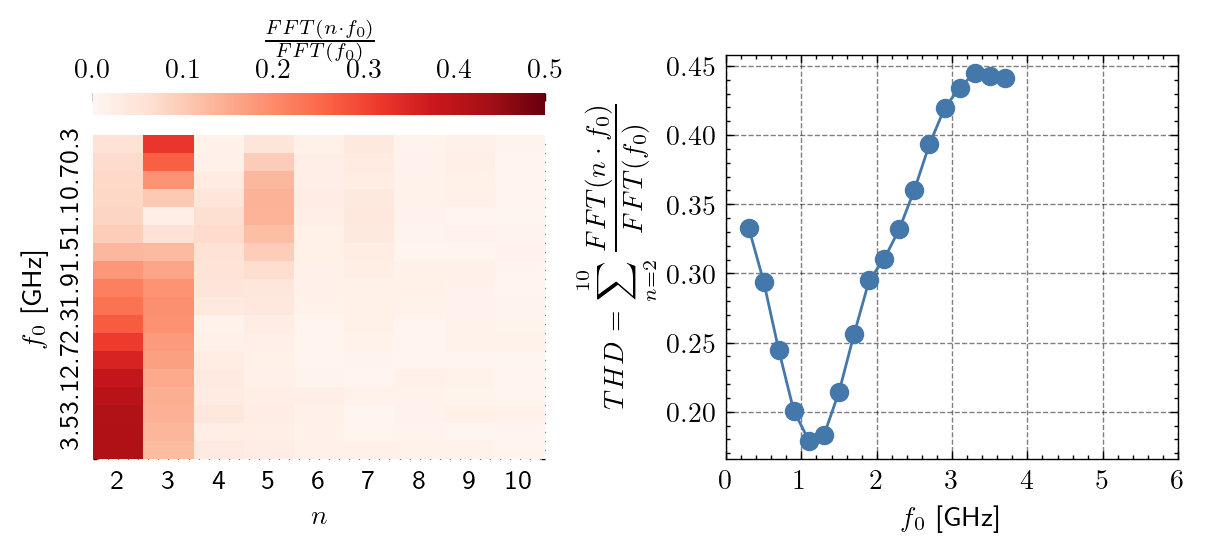

In [66]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot(1,2,1)
    fig.set_figwidth(fig.get_figwidth()*2)

    ax  = sns.heatmap(df_nonlinear_new.T, cmap='Reds', ax=ax, cbar_kws={'label':"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$", "location":"top"}, vmin=0, vmax=0.5)
    ax.set_ylabel("$f_0$ [GHz]")
    ax.set_xlabel("$n$")

    # for i, col in enumerate(df_nonlinear.columns):
    #     ax.plot(np.arange(2,len(df_fft_amplitudes)+1), df_nonlinear[col], c=cmap((i+1)/(len(df_nonlinear.columns))))

    # ax.set_ylabel("$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$")
    # ax.set_xlabel("$n$")

    ax  = fig.add_subplot(1,2,2)
    ax  = np.sqrt((df_nonlinear**2).sum()).plot(ax=ax, marker='o')
    ax.set_ylabel("$THD$ = $\displaystyle\sum_{n=2}^{10}\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$")
    ax.set_xlabel("$f_0$ [GHz]")
    ax.set_xlim(0,6)

    plt.subplots_adjust(wspace=0.4)
    plt.locator_params(axis='x', nbins=8)

    # fig.savefig("plots/harmonic_generation.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/harmonic_generation.svg", transparent=True, bbox_inches='tight')

KeyError: 4.5

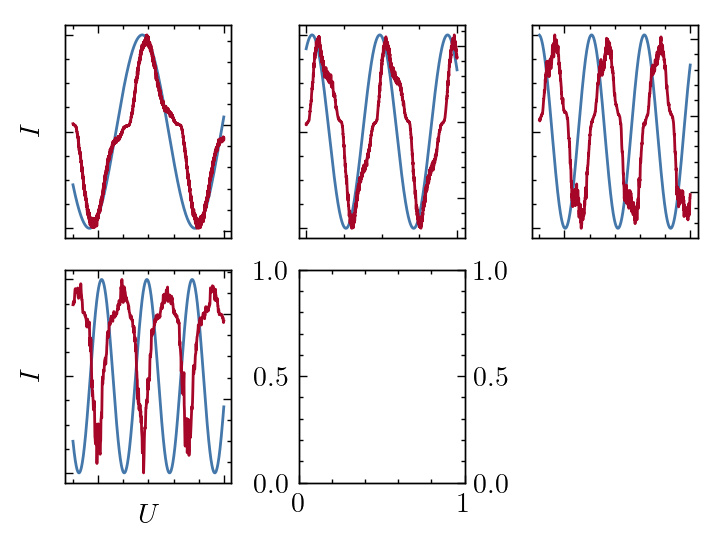

In [57]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
N_voltages      = 10000
time            = step_size*np.arange(N_voltages)[1:]
n_cols          = 3
n_rows          = 2
f_vals          = [0.3, 0.7, 1.5, 3.5, 4.5, 5.5]
xmin            = [7000,8000,8800,9400,9500,9600]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')

    for i, f in enumerate(f_vals):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        ax2             = ax.twinx()
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values

        ax.plot(time[xmin[i]:], input_signal[xmin[i]:])
        ax2.plot(time[xmin[i]:], signal[xmin[i]:], c=nanonets_utils.red_color)

        # ax  = fig.add_subplot(4,2,(2+1)*i+1)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax2.set_yticklabels("")

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')

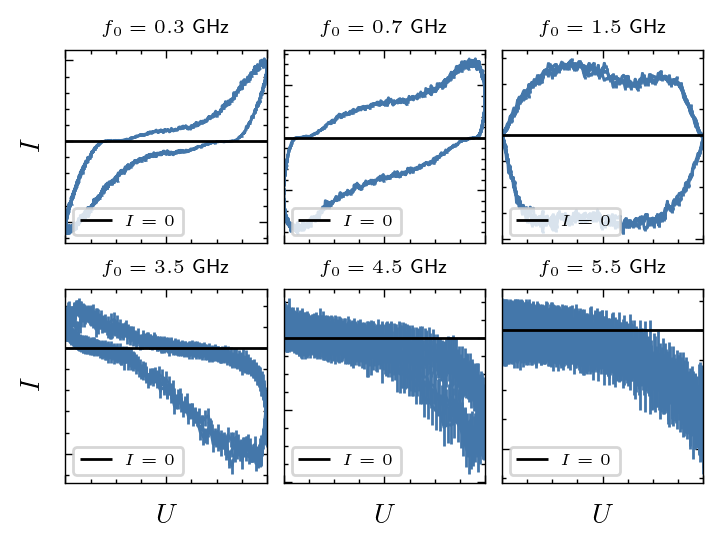

In [351]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
time            = step_size*np.arange(N_voltages)[1:]
n_cols          = 3
n_rows          = 2
f_vals          = [0.3, 0.7, 1.5, 3.5, 4.5, 5.5]
xmin            = [7000,8000,8800,9400,9500,9600]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')

    for i, f in enumerate(f_vals):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values
        error           = dic[f]['Error'].values

        ax.errorbar(input_signal[xmin[i]:], signal[xmin[i]:], error[xmin[i]])
        ax.hlines(0,-0.2,0.2, 'black', zorder=10, label="$I = 0$")
        ax.set_xlim(-0.2,0.2)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.legend(fontsize='xx-small', loc='lower left', frameon=True)

        ax.set_title(f'$f_0 = {f}$ GHz', fontsize='x-small')

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')
    
    # fig.savefig("plots/I_V_harmoic_generation.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/I_V_harmoic_generation.svg", transparent=True, bbox_inches='tight')

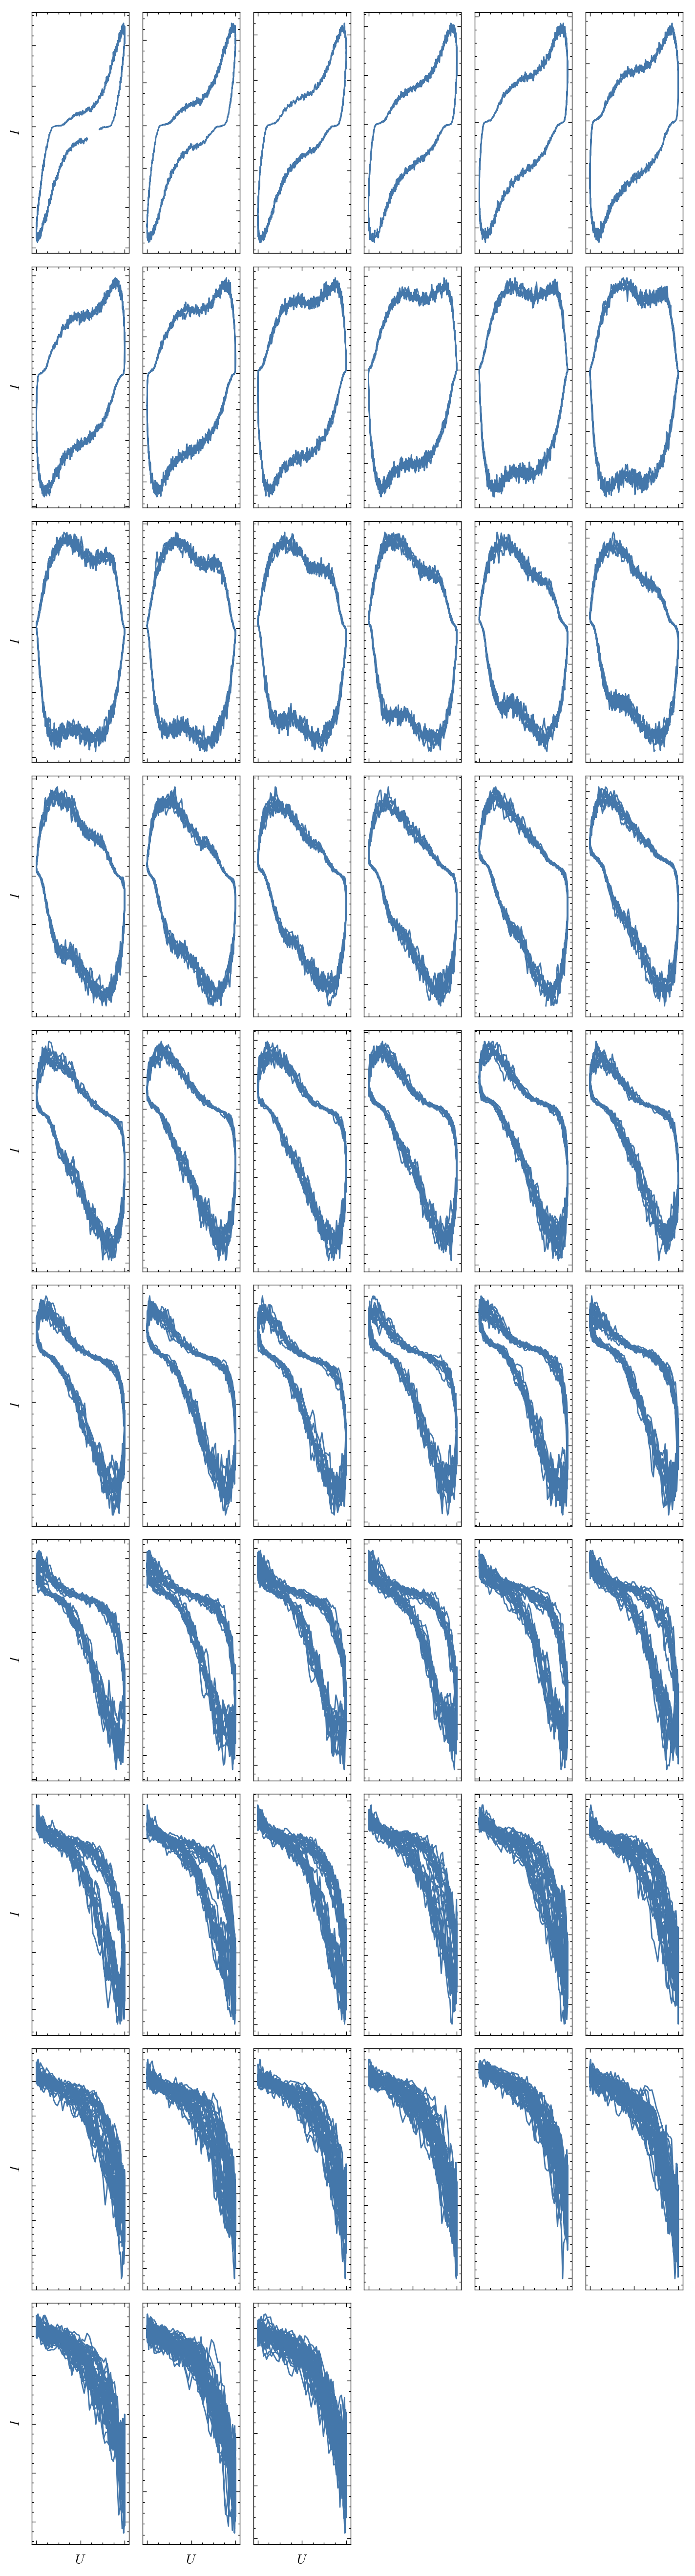

In [297]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
time            = step_size*np.arange(N_voltages)[1:]
n_cols          = 6
n_rows          = 10
f_vals          = [0.3, 1.5, 2.8, 4.5]
xmin            = 8000

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figheight(fig.get_figheight()*10)
    fig.set_figwidth(fig.get_figwidth()*2)

    for i, f in enumerate(dic.keys()):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values

        ax.plot(input_signal[xmin:], signal[xmin:])
        ax.set_xticklabels("")
        ax.set_yticklabels("")

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')

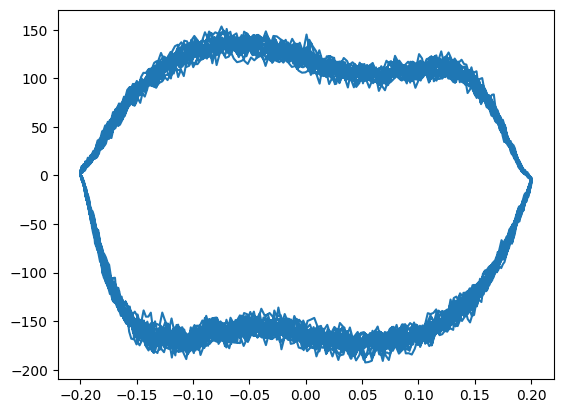

In [264]:
plt.plot(input_signal[800:], signal[800:])

---

### Charge Redistribtuion

In [212]:
dic_s = {f : pd.read_csv(f"uniform/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2_{f}.csv") for f in np.round(np.arange(0.3,6,0.1),2)}

for key, df in dic_s.items():

    dic_s[key].columns = np.arange(0,49)

In [159]:
def multiplot_observable_based_on_network(x_vals : pd.DataFrame, y_vals : pd.DataFrame, N : int,
                                          fig_scale=(1.5,1.5), x_lim=None, y_lim=None, y_label='y',
                                          x_label='x', log_x=False, log_y=False, style_context=["science","bright","grid"], y_full_range=False):
    
    if type(x_vals) == type(np.array([])):

        x_vals_new = pd.DataFrame()

        for col in y_vals.columns:

            x_vals_new[col] = x_vals
    
        x_vals = x_vals_new

    with plt.style.context(style_context):
        
        fig, axs    = plt.subplots(ncols=N, nrows=N, layout='constrained')
        width       = fig.get_figwidth()
        fig.set_figwidth(width*fig_scale[0])
        fig.set_figheight(width*fig_scale[1])

        if x_lim == None:
            x_lim = [x_vals.min().min(), x_vals.max().max()]

        if y_lim == None:
            y_lim = [y_vals.min().min(), y_vals.max().max()]

        i = 0

        for row in np.arange((N-1),-1,-1):
            
            for col in range(0,N):

                axs[row,col].plot(x_vals.loc[:,i], y_vals.loc[:,i])
                
                axs[row,col].set_xlim(x_lim[0],x_lim[1])
                axs[row,col].set_ylim(y_lim[0],y_lim[1])

                if i % N != 0:
                    axs[row,col].set_yticklabels("")
                else:    
                    axs[row,col].set_ylabel(y_label)

                if (i > N-1):
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel(x_label)

                if log_x:
                    axs[row,col].set_xscale('log')

                if log_y:
                    axs[row,col].set_yscale('log')

                if y_full_range:
                    axs[row,col].set_ylim(y_vals.loc[:,i].min(),y_vals.loc[:,i].max())
                    axs[row,col].set_yticklabels("")

                i += 1

    return fig, axs

In [156]:
df_low          = dic_s[1.6].copy()
df_low.columns  = np.arange(0,49)
df_high         = dic_s[4.5].copy()
df_high.columns = np.arange(0,49)

In [222]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [235]:
amplitude       = 0.2
input_signal    = amplitude*np.cos(freq*time*1e8)

Text(0.5, 0.98, '$f_0 = 1.6$ GHz')

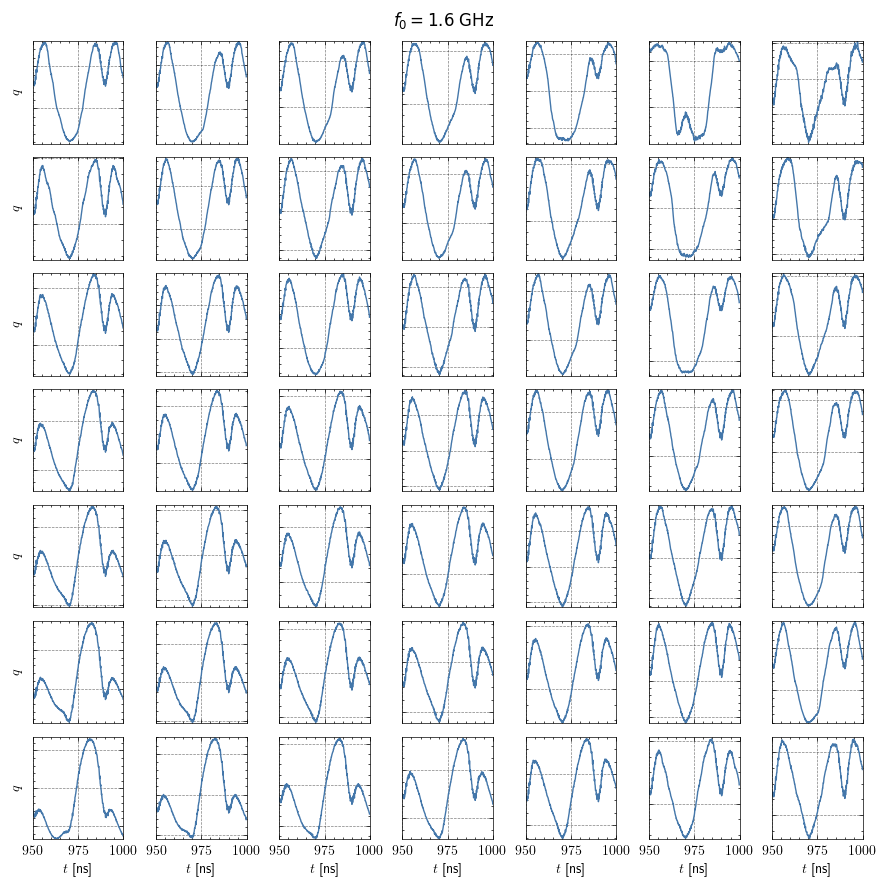

In [164]:
fig, ax = multiplot_observable_based_on_network(time, df_low, 7, fig_scale=(2.5,2.5), x_lim=(950,1000), y_lim=(-1,10),
                                                y_full_range=True, y_label="$q$", x_label="$t$ [ns]")
fig.suptitle("$f_0 = 1.6$ GHz")

Text(0.5, 0.98, '$f_0 = 4.8$ GHz')

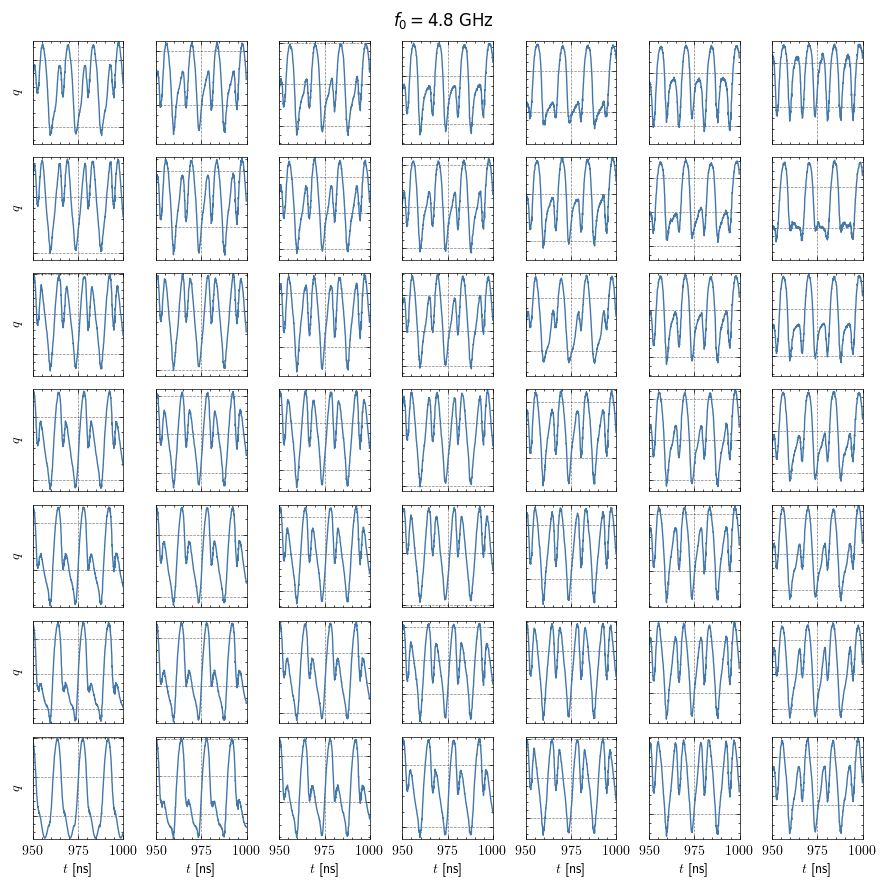

In [165]:
fig, ax = multiplot_observable_based_on_network(time, df_high, 7, fig_scale=(2.5,2.5), x_lim=(950,1000), y_lim=(-1,10),
                                                y_full_range=True, y_label="$q$", x_label="$t$ [ns]")
fig.suptitle("$f_0 = 4.8$ GHz")

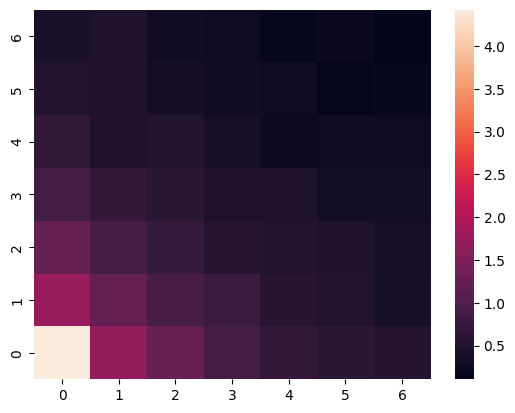

In [197]:
ax = sns.heatmap(np.reshape(df_high.std().values,(-1,7)))
ax.invert_yaxis()

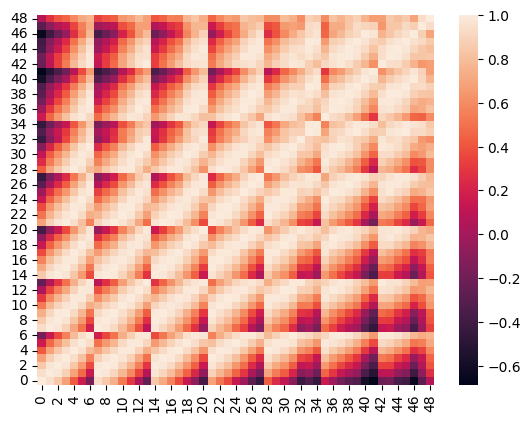

In [200]:
ax = sns.heatmap(df_high.corr())
ax.invert_yaxis()

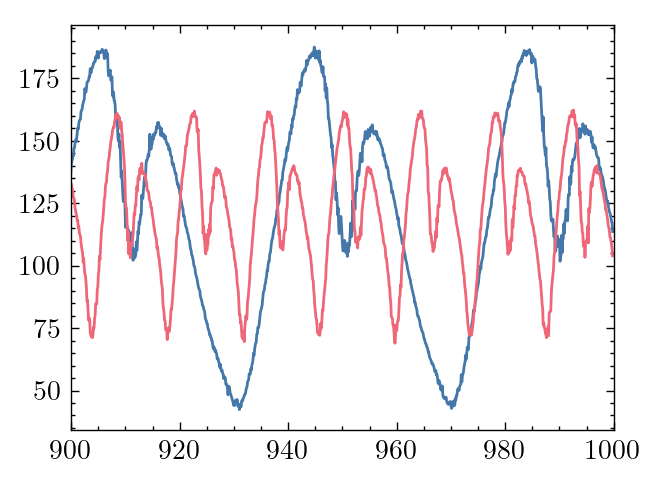

In [176]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    ax.plot(time, df_low.sum(axis=1))
    ax.plot(time, df_high.sum(axis=1))

    ax.set_xlim(900,1000)

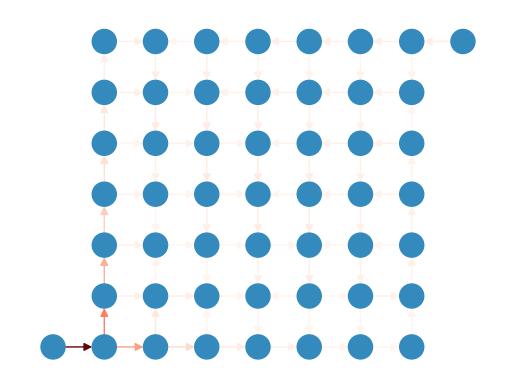

In [209]:
topology_parameter = {
    "Nx"    :   7,
    "Ny"    :   7,
    "Nz"    :   1,
    "e_pos" :   [[0,0,0],[6,6,0]]
}

sim_class   = nanonets.simulation('cubic', topology_parameter)
fig, ax     = nanonets_utils.display_network_currents(path="uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=2_4.5.csv", row=[500,1000],
                                                      N_electrodes=2, pos=sim_class.pos, charge_landscape=False)

---

In [289]:
def average_outputs(folder, N_stat, N_threads):

    values          = [pd.read_csv(folder+f"/Nx=7_Ny=7_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
    means           = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns)
    means['Error']  = np.std(values,axis=0)[:,-2]/np.sqrt(len(values))

    means.to_csv(folder+f"/Nx=7_Ny=7_Nz=1_Ne=2.csv", index=0)

def average_states(folder, N_stat, N_threads):

    values  = [pd.read_csv(folder+f"/mean_state_Nx=7_Ny=7_Nz=1_Ne=2_t{j}_s{k}.csv") for j in range(N_threads) for k in range(N_stat)]
    means   = pd.DataFrame(np.mean(values, axis=0),columns=values[0].columns).round(3)
    
    means.to_csv(folder+f"/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv", index=0)

freq = "f3/"

# Combine output currents
average_outputs(f"1I_1O_R_corr/data/{freq}R_50/", 10, 10)
average_outputs(f"1I_1O_R_corr/data/{freq}R_100/", 10, 10)
average_outputs(f"1I_1O_R_corr/data/{freq}R_200/", 10, 10)
# average_outputs(f"1I_1O_R_corr/data/{freq}R_400/", 10, 10)

# Combine states
average_states(f"1I_1O_R_corr/data/{freq}R_50/", 10 , 10)
average_states(f"1I_1O_R_corr/data/{freq}R_100/", 10 , 10)
average_states(f"1I_1O_R_corr/data/{freq}R_200/", 10 , 10)
# average_states(f"1I_1O_R_corr/data/{freq}R_400/", 10 , 10)

In [2]:
freq                = "f3/"
results             = pd.DataFrame()
results["t"]        = np.loadtxt("1I_1O_R_corr/time.csv")[1:]*10**9
results['U']        = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_50/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']
results["R_50_I"]   = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_50/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["R_50_uI"]  = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_50/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
results["R_100_I"]  = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_100/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["R_100_uI"] = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_100/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
results["R_200_I"]  = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_200/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
results["R_200_uI"] = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_200/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
# results["R_400_I"]  = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_400/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
# results["R_400_uI"] = pd.read_csv(f"1I_1O_R_corr/data/{freq}R_400/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']

results = results.iloc[1000:,:].reset_index(drop=True)
results

FileNotFoundError: 1I_1O_R_corr/time.csv not found.

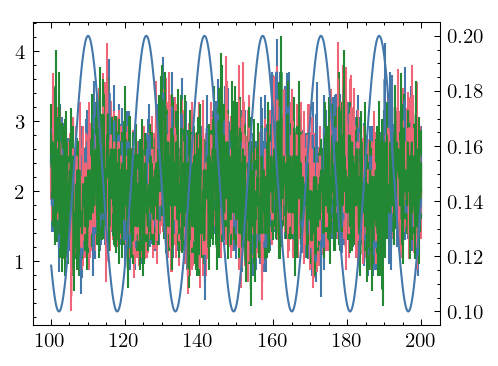

In [291]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'])
    ax.errorbar(results['t'], results['R_50_I']/1000, results['R_50_uI']/1000)
    ax.errorbar(results['t'], results['R_100_I']/1000, results['R_100_uI']/1000)
    ax.errorbar(results['t'], results['R_200_I']/1000, results['R_200_uI']/1000)
    # ax.errorbar(results['t'], results['R_400_I'], results['R_400_uI'])

In [ ]:
# data = {}

# results         = pd.DataFrame()
# results["t"]    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
# results['U']    = pd.read_csv("1I_1O/data/f1/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']
# results["I"]    = pd.read_csv("1I_1O/data/f1/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
# results["uI"]   = pd.read_csv("1I_1O/data/f1/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
# data[5e7]       = results

# results         = pd.DataFrame()
# results["t"]    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
# results['U']    = pd.read_csv("1I_1O/data/f2/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']
# results["I"]    = pd.read_csv("1I_1O/data/f2/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
# results["uI"]   = pd.read_csv("1I_1O/data/f2/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
# data[10e7]      = results

# results         = pd.DataFrame()
# results["t"]    = np.loadtxt("1I_1O/time.csv")[1:]*10**9
# results['U']    = pd.read_csv("1I_1O/data/f3/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']
# results["I"]    = pd.read_csv("1I_1O/data/f3/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
# results["uI"]   = pd.read_csv("1I_1O/data/f3/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
# data[20e7]      = results

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=150)
#     fig.set_figheight(fig.get_figheight())
    
#     ax  = fig.add_subplot(3,1,1)
#     ax.errorbar(data[5e7]['t'], data[5e7]['I']/1000, data[5e7]['uI']/1000)
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(-6,6)
#     ax.set_xticklabels("")

#     ax2 = ax.twinx()
#     ax2.plot(data[5e7]['t'], data[5e7]['U'], c='#A60628', label=f"$f = {5e7 / 10**9}$ nHz")
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax2.legend(fontsize='x-small', loc='upper right', frameon=True)

#     ax  = fig.add_subplot(3,1,2)
#     ax.errorbar(data[10e7]['t'], data[10e7]['I']/1000, data[10e7]['uI']/1000)
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(-6,6)
#     ax.set_xticklabels("")

#     ax2 = ax.twinx()
#     ax2.plot(data[10e7]['t'], data[10e7]['U'], c='#A60628', label=f"$f = {10e7 / 10**9}$ nHz")
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax2.legend(fontsize='x-small', loc='upper right', frameon=True)

#     ax  = fig.add_subplot(3,1,3)
#     ax.errorbar(data[20e7]['t'], data[20e7]['I']/1000, data[20e7]['uI']/1000)
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(-6,6)
#     ax.set_xlabel("$t$ [ns]")

#     ax2 = ax.twinx()
#     ax2.plot(data[20e7]['t'], data[20e7]['U'], c='#A60628', label=f"$f = {20e7 / 10**9}$ nHz")
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax2.legend(fontsize='x-small', loc='upper right', frameon=True)


In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=150)
#     fig.set_figheight(fig.get_figheight())
    
#     ax  = fig.add_subplot(3,1,1)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

#     ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='uniform')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.legend()

#     ax  = fig.add_subplot(3,1,2)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['r_I']/1000, results['r_uI']/1000, label='r-Island')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.legend()

#     ax  = fig.add_subplot(3,1,3)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['R_I']/1000, results['R_uI']/1000, label='R-Island')
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_xlabel("$t$ [ns]")
#     ax.legend()

#     fig.savefig('plots/i_o_comp.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/i_o_comp.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# x   = results["t"].values
# y   = results["U"].values

# def update(num, x, y, line):
#     line.set_data(x[:num], y[:num])
#     # line.axes.axis([xmin,xmax,ymin,ymax])
    
#     return line,

# with plt.style.context(["science","bright"]):

#     fig     = plt.figure(dpi=150)
#     ax      = fig.add_subplot()
#     # ax.set_xlabel("$t$ [ns]")
#     # ax.set_ylabel("$U_0$ [mV]")
    
#     line,   = ax.plot(x, y, lw=3)
#     ani     = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line], interval=50, repeat_delay=500)

# ani.save("plots/input.gif")

In [292]:
dic = {
    "R_50"    : pd.read_csv(f"1I_1O_R_corr/data/{freq}R_50/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_100"   : pd.read_csv(f"1I_1O_R_corr/data/{freq}R_100/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_200"   : pd.read_csv(f"1I_1O_R_corr/data/{freq}R_200/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    # "R_400"   : pd.read_csv(f"1I_1O_R_corr/data/{freq}R_400/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
}

for key, df in dic.items():
    dic[key] = df.iloc[1000:,:].reset_index(drop=True)

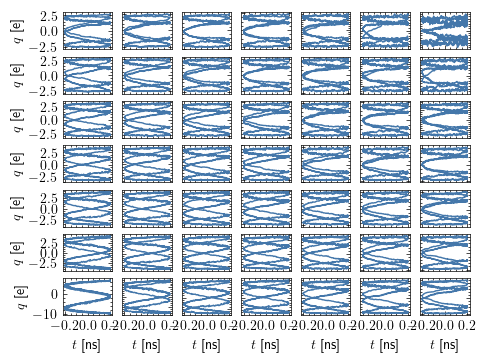

In [293]:
def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

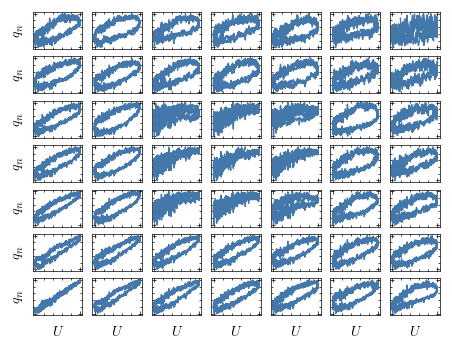

In [282]:
key = "R_200"

with plt.style.context(["science","bright"]):

    fig, axs = plt.subplots(ncols=7, nrows=7)

    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*1.5)

    i = 0

    for row in np.arange(6,-1,-1):
        for col in range(0,7):

            axs[row,col].plot(results["U"]*1000, scale_landscape(dic[key][f"{i}"]).values)

            if i >= 7:
                axs[row,col].set_xticklabels("")
            else:
                axs[row,col].set_xticklabels("")
                axs[row,col].set_xlabel("$U$")

            if i % 7 != 0:
                axs[row,col].set_yticklabels("")
            else:
                axs[row,col].set_yticklabels("")
                axs[row,col].set_ylabel("$q_n$")

            i += 1

    # fig.savefig('plots/state_vs_time.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_time.pdf', bbox_inches='tight', transparent=False)

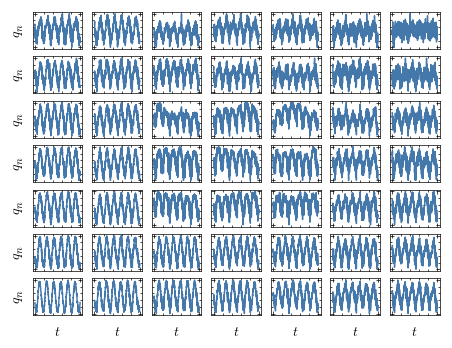

In [294]:
key = "R_200"

with plt.style.context(["science","bright"]):

    fig, axs = plt.subplots(ncols=7, nrows=7)

    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*1.5)

    i = 0

    for row in np.arange(6,-1,-1):
        for col in range(0,7):

            axs[row,col].plot(results["t"], scale_landscape(dic[key][f"{i}"]).values)

            if i >= 7:
                axs[row,col].set_xticklabels("")
            else:
                axs[row,col].set_xticklabels("")
                axs[row,col].set_xlabel("$t$")

            if i % 7 != 0:
                axs[row,col].set_yticklabels("")
            else:
                axs[row,col].set_yticklabels("")
                axs[row,col].set_ylabel("$q_n$")

            i += 1

    # fig.savefig('plots/state_vs_time.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_time.pdf', bbox_inches='tight', transparent=False)

In [260]:
from scipy.fft import fft, rfft, fftfreq, rfftfreq

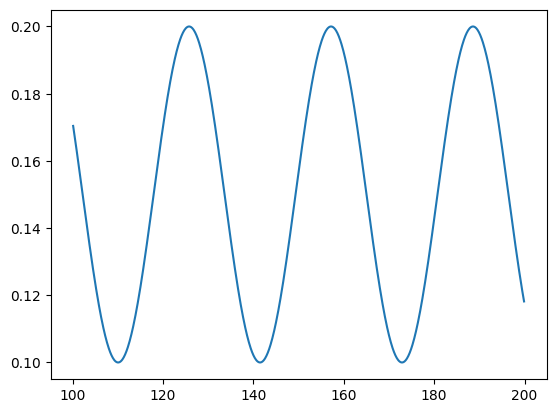

In [285]:
plt.plot(results["t"], results["U"])

In [284]:
def return_fft(arr : np.array, step_size : float):

    arr_norm    = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    sample_rate = 1/step_size

    xf      = rfftfreq(len(arr), 1. / sample_rate)
    yf      = np.abs(rfft(arr_norm))

    # xf          = np.fft.rfftfreq(len(arr), d=1./sample_rate)
    # yf          = 2*np.abs(np.fft.rfft(arr))/len(arr)

    return xf, yf

In [265]:
arr1 = results["U"].values
arr2 = dic["R_200"].values[:,24]
arr3 = results["R_200_I"].values

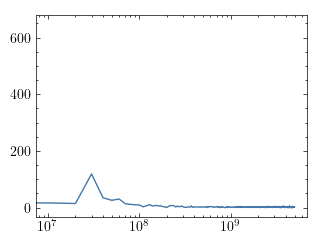

In [288]:
arr     = dic["R_200"].values[:,24]
xf, yf  = return_fft(arr, 1e-10)

with plt.style.context(["science","bright"]):
    
    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(xf, yf)
    ax.set_xscale("log")

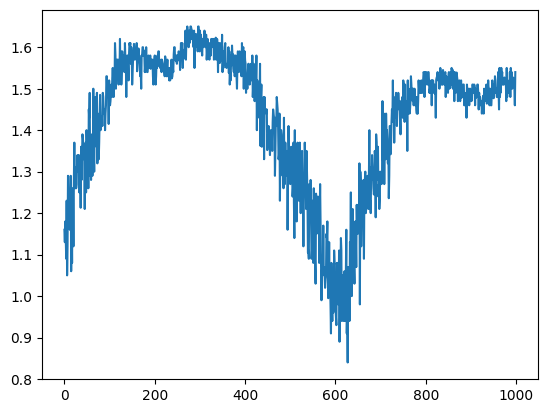

In [266]:
plt.plot(arr2)

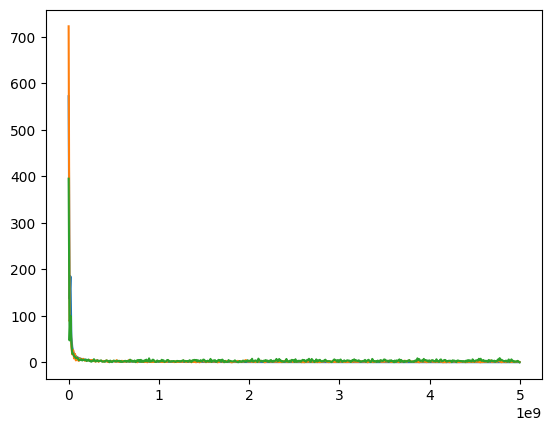

In [268]:
step_size   = 1e-10
x, y        = return_fft(arr1, step_size)
plt.plot(x, y)
x, y        = return_fft(arr2, step_size)
plt.plot(x, y)
x, y        = return_fft(arr3, step_size)
plt.plot(x, y)
plt.xlim(0,1e8)

In [41]:
def nonlinear_index(df : pd.DataFrame, main_frequency : float, sample_rate : float, time_scale=10**6, number_of_frequencies=10):

    N_values    = len(df)
    values      = []

    for col in df.columns:

        # Fourier Spectrum
        arr     = df.loc[:,col].values
        xf      = rfftfreq(N_values-1, 1 / sample_rate)/time_scale
        yf      = 2*np.abs(rfft(arr))/N_values
        df_f    = pd.DataFrame([xf, yf]).T
        df_f    = df_f[df_f[0] >= main_frequency/time_scale]
        df_f    = df_f.loc[df_f.loc[:,1].nlargest(number_of_frequencies).index].reset_index(drop=True)

        a       = df_f.iloc[1:,1].sum()
        b       = df_f.iloc[0,1]

        n_idx   = a/b
        values.append(n_idx)

    return values

In [ ]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

In [ ]:
node_size = 150

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
fig.savefig('plots/network_plot.svg', bbox_inches='tight', transparent=True)
fig.savefig('plots/network_plot.pdf', bbox_inches='tight', transparent=False)

node_size = np.repeat(150, 51)

for i in [16,17,18,23,24,25,30,31,32]:
    node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
fig.savefig('plots/network_plot_radius.svg', bbox_inches='tight', transparent=True)
fig.savefig('plots/network_plot_radius.pdf', bbox_inches='tight', transparent=False)